# Heterogeneous Effects

**Author**
> - [Paul Schrimpf *UBC*](https://economics.ubc.ca/faculty-and-staff/paul-schrimpf/)

**Prerequisites**

- {doc}`Regression <../tools/regression>`
- {doc}`Machine Learning in Economics <ml_in_economics>`

**Outcomes**

- Understand potential outcomes and treatment effects
- Apply generic machine learning inference to data from a randomized experiment

```{literalinclude} ../_static/colab_full.raw
```

In [1]:
import pandas as pd
import numpy as np
import patsy
from sklearn import linear_model, ensemble, base, neural_network
import statsmodels.formula.api as smf
import statsmodels.api as sm
from sklearn.utils._testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In this notebook, we will learn how to apply machine learning methods to analyze
results of a randomized experiment. We typically begin analyzing
experimental results by calculating the difference in mean
outcomes between the treated and control groups. This difference estimates well
the average treatment effect. We can obtain more
nuanced results by recognizing that the effect of most experiments
might be heterogeneous. That is, different people could be affected by
the experiment differently. We will use machine learning methods to
explore this heterogeneity in treatment effects.


## Background and Data

We are going to use data from a randomized  experiment in Indonesia
called Program Keluarga Harapan (PKH). PKH was a conditional cash
transfer program designed to improve child health. Eligible pregnant
women would receive a cash transfer if they attended at least 4
pre-natal and 2 post-natal visits, received iron supplements, and had
their baby delivered by a doctor or midwife. The cash transfers were
given quarterly and were about 60-220 dollars or 15-20 percent of
quarterly consumption. PKH eligibility was randomly assigned at the
kecamatan (district) level. All pregnant women living in a treated
kecamatan could choose to participate in the experiment. For more
information see {cite}`het-alatas2011` or {cite}`het-triyana2016`.

We are using the data provided with {cite}`het-triyana2016`.

In [2]:
url = "https://datascience.quantecon.org/assets/data/Triyana_2016_price_women_clean.csv"
df = pd.read_csv(url)
df.describe()

,rid_panel,prov,Location_ID,dist,wave,edu,agecat,log_xp_percap,rhr031,rhr032,...,hh_xp_all,tv,parabola,fridge,motorbike,car,pig,goat,cow,horse
count,1.225100e+04,22768.000000,2.277100e+04,22771.000000,22771.000000,22771.000000,22771.000000,22771.000000,22771.000000,22771.000000,...,22771.000000,22771.000000,22771.000000,22771.000000,22771.000000,22771.000000,22771.000000,22771.00000,22771.000000,22771.000000
mean,3.406884e+12,42.761156,4.286882e+06,431842.012033,1.847174,52.765799,4.043081,13.420404,0.675157,0.754908,...,3.839181,0.754908,0.482148,0.498661,0.594792,0.470511,0.536691,0.53858,0.515041,0.470247
std,1.944106e+12,14.241982,1.423541e+06,143917.353784,0.875323,45.833778,1.280589,1.534089,0.468326,0.430151,...,1.481982,0.430151,0.499692,0.500009,0.490943,0.499141,0.498663,0.49852,0.499785,0.499125
min,1.100103e+10,31.000000,3.175010e+06,3524.000000,1.000000,6.000000,0.000000,7.461401,0.000000,0.000000,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
25%,1.731008e+12,32.000000,3.210180e+06,323210.000000,1.000000,6.000000,3.000000,11.972721,0.000000,1.000000,...,3.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
50%,3.491004e+12,35.000000,3.517171e+06,353517.000000,2.000000,12.000000,5.000000,12.851639,1.000000,1.000000,...,5.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.00000,1.000000,0.000000
75%,5.061008e+12,53.000000,5.307020e+06,535307.000000,3.000000,99.000000,5.000000,15.018967,1.000000,1.000000,...,5.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000
max,6.681013e+12,75.000000,7.571030e+06,757571.000000,3.000000,99.000000,5.000000,15.018967,1.000000,1.000000,...,5.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000


## Potential Outcomes and Treatment Effects

Since program eligibility was randomly assigned (and what
policymakers could choose to change), we will focus on estimating
the effect of eligibility. We will let
$d_i$ be a 1 if person $i$ was eligible and be 0 if not.
Let $y_i$ be an outcome of interest. Below, we
will look at midwife usage and birth weight as outcomes.

It is
useful to think about potential outcomes of the treatment. The potential treated
outcome is $y_i(1)$. For subjects who actually were treated,
$y_i(1) = y_i$ is the observed outcome. For untreated subjects,
$y_i(1)$ is what mother i 's baby's birth weight would have
been if she had been eligible for the program. Similarly, we can
define the potential untreated outcome $y_i(0)$ .

The individual treatment effect for subject i is $y_i(1) - y_i(0)$.

Individual treatment effects are impossible to know since we always
only observe $y_i(1)$ or $y_i(0)$, but never both.

When treatment is randomly assigned, we can estimate average treatment
effects because

$$
\begin{align*}
E[y_i(1) - y_i(0) ] = & E[y_i(1)] - E[y_i(0)] \\
& \text{random assignment } \\
= & E[y_i(1) | d_i = 1] - E[y_i(0) | d_i = 0] \\
= & E[y_i | d_i = 1] - E[y_i | d_i = 0 ]
\end{align*}
$$

### Average Treatment Effects

Let's estimate the average treatment effect.

In [3]:
# some data prep for later
formula = """
bw ~ pkh_kec_ever +
  C(edu)*C(agecat) + log_xp_percap + hh_land + hh_home + C(dist) +
  hh_phone + hh_rf_tile + hh_rf_shingle + hh_rf_fiber +
  hh_wall_plaster + hh_wall_brick + hh_wall_wood + hh_wall_fiber +
  hh_fl_tile + hh_fl_plaster + hh_fl_wood + hh_fl_dirt +
  hh_water_pam + hh_water_mechwell + hh_water_well + hh_water_spring + hh_water_river +
  hh_waterhome +
  hh_toilet_own + hh_toilet_pub + hh_toilet_none +
  hh_waste_tank + hh_waste_hole + hh_waste_river + hh_waste_field +
  hh_kitchen +
  hh_cook_wood + hh_cook_kerosene + hh_cook_gas +
  tv + fridge + motorbike + car + goat + cow + horse
"""
bw, X = patsy.dmatrices(formula, df, return_type="dataframe")
# some categories are empty after dropping rows will Null, drop now
X = X.loc[:, X.sum() > 0]
bw = bw.iloc[:, 0]
treatment_variable = "pkh_kec_ever"
treatment = X["pkh_kec_ever"]
Xl = X.drop(["Intercept", "pkh_kec_ever", "C(dist)[T.313175]"], axis=1)
#scale = bw.std()
#center = bw.mean()
loc_id = df.loc[X.index, "Location_ID"].astype("category")

import re
# remove [ ] from names for compatibility with xgboost
Xl = Xl.rename(columns=lambda x: re.sub('\[|\]','_',x))

In [4]:
# Estimate average treatment effects
from statsmodels.iolib.summary2 import summary_col
tmp = pd.DataFrame(dict(birthweight=bw,treatment=treatment,assisted_delivery=df.loc[X.index, "good_assisted_delivery"]))
usage = smf.ols("assisted_delivery ~ treatment", data=tmp).fit(cov_type="cluster", cov_kwds={'groups':loc_id})
health= smf.ols("bw ~ treatment", data=tmp).fit(cov_type="cluster", cov_kwds={'groups':loc_id})
summary_col([usage, health])

,assisted_delivery,bw
Intercept,0.7827,3173.4067
,(0.0124),(10.2323)
treatment,0.0235,-14.8992
,(0.0192),(24.6304)
R-squared,0.0004,0.0001
R-squared Adj.,0.0002,-0.0001


The program did increase the percent of births assisted by a medical
professional, but on average, did not affect birth weight.

### Conditional Average Treatment Effects

Although we can never estimate individual treatment effects, the
logic that lets us estimate unconditional average treatment effects
also suggests that we can estimate conditional average treatment effects.

$$
\begin{align*}
E[y_i(1) - y_i(0) |X_i=x] = & E[y_i(1)|X_i = x] - E[y_i(0)|X_i=x] \\
& \text{random assignment } \\
= & E[y_i(1) | d_i = 1, X_i=x] - E[y_i(0) | d_i = 0, X_i=x] \\
= & E[y_i | d_i = 1, X_i = x] - E[y_i | d_i = 0, X_i=x ]
\end{align*}
$$

Conditional average treatment effects tell us whether there are
identifiable (by X) groups of people for with varying treatment effects vary.

Since conditional average treatment effects involve conditional
expectations, machine learning methods might be useful.

However, if we want to be able to perform statistical inference, we
must use machine learning methods carefully. We will detail one
approach below. {cite}`het-athey2016b` and {cite}`het-wager2018` are
alternative approaches.

## Generic Machine Learning Inference

In this section, we will describe the "generic machine learning
inference" method of {cite}`het-cddf2018` to explore heterogeneity in
conditional average treatment effects.

This approach allows any
machine learning method to be used to estimate $E[y_i(1) -
y_i(0) |X_i=x]$.

Inference for functions estimated by machine learning methods is
typically either impossible or requires very restrictive assumptions.
{cite}`het-cddf2018` gets around this problem by focusing on inference for
certain summary statistics of the machine learning prediction for
$E[y_i(1) - y_i(0) |X_i=x]$ rather than
$E[y_i(1) - y_i(0) |X_i=x]$ itself.

### Best Linear Projection of CATE

Let $s_0(x) = E[y_i(1) - y_i(0) |X_i=x]$ denote the true
conditional average treatment effect. Let $S(x)$ be an estimate
or noisy proxy for $s_0(x)$. One way to summarize how well
$S(x)$ approximates $s_0(x)$ is to look at the best linear
projection of $s_0(x)$ on $S(x)$.

$$
\DeclareMathOperator*{\argmin}{arg\,min}
\beta_0, \beta_1 = \argmin_{b_0,b_1} E[(s_0(x) -
b_0 - b_1 (S(x)-E[S(x)]))^2]
$$

Showing that $\beta_0 = E[y_i(1) - y_i(0)]$
is the unconditional average treatment effect is not difficult. More interestingly,
$\beta_1$ is related to how well $S(x)$ approximates
$s_0(x)$. If $S(x) = s_0(x)$, then $\beta_1=1$. If
$S(x)$ is completely uncorrelated with $s_0(x)$, then
$\beta_1 = 0$.

The best linear projection of the conditional average treatment
effect tells us something about how well $S(x)$ approximates
$s_0(x)$, but does not directly quantify how much the conditional
average treatment effect varies with $x$. We could try looking
at $S(x)$ directly, but if $x$ is high dimensional, reporting or visualizing
$S(x)$ will be difficult. Moreover, most
machine learning methods have no satisfactory method to determine inferences
on $S(x)$. This is very problematic if we want to use
$S(x)$ to shape future policy decisions. For example, we might
want to use $S(x)$ to target the treatment to people with
different $x$. If we do this, we need to know whether the
estimated differences across $x$ in $S(x)$ are precise or
caused by noise.

### Grouped Average Treatment Effects

To deal with both these issues, {cite}`het-cddf2018` focuses on
grouped average treatment effects (GATE) with groups defined by
$S(x)$. Partition the data into a fixed, finite number of groups
based on $S(x)$ . Let
$G_{k}(x) = 1\{\ell_{k-1} \leq S(x) \leq \ell_k \}$ where
$\ell_k$ could be a constant chosen by the researcher or evenly
spaced quantiles of $S(x)$. The $k$ th grouped average
treatment effect is then $\gamma_k = E[y(1) - y(0) | G_k(x)]$.
If the true $s_0(x)$ is not constant, and $S(x)$
approximates $s_0(x)$ well, then the grouped average treatment
effects will increase with $k$. If the conditional average treatment effect
has no heterogeneity (i.e. $s_0(x)$ is constant) and/or
$S(x)$ is a poor approximation to $s_0(x)$,
then the grouped average treatment effect will tend to
be constant with $k$ and may even be non-monotonic due to
estimation error.

### Estimation

We can estimate both the best linear projection of the conditional average treatment
effect and the grouped treatment effects by using
particular regressions. Let $B(x)$ be an estimate of the outcome
conditional on no treatment, i.e. $B(x) = \widehat{E[y(0)|x]}$
. Then the estimates of $\beta$ from the regression

$$
y_i = \alpha_0 + \alpha_1 B(x_i) + \beta_0 (d_i-P(d=1)) + \beta_1
(d_i-P(d=1))(S(x_i) - E[S(x_i)]) + \epsilon_i
$$

are consistent estimates of the best linear projection of the
conditional average treatment effect if $B(x_i)$ and
$S(x_i)$ are uncorrelated with $y_i$ . We can ensure that
$B(x_i)$ and $S(x_i)$ are uncorrelated with $y_i$ by
using the familiar idea of sample-splitting and cross-validation. The
usual regression standard errors will also be valid.

Similarly, we can estimate grouped average treatment effects from the
following regression.

$$
y_i = \alpha_0 + \alpha_1 B(x_i) + \sum_k \gamma_k (d_i-P(d=1)) 1(G_k(x_i)) +
u_i
$$

The resulting estimates of $\gamma_k$ will be consistent and
asymptotically normal with the usual regression standard errors.

In [5]:
# for clustering standard errors
def get_treatment_se(fit, cluster_id, rows=None):
    if cluster_id is not None:
        if rows is None:
            rows = [True] * len(cluster_id)
        vcov = sm.stats.sandwich_covariance.cov_cluster(fit, cluster_id.loc[rows])
        return np.sqrt(np.diag(vcov))

    return fit.HC0_se

In [6]:
def generic_ml_model(x, y, treatment, model, n_split=10, n_group=5, cluster_id=None):
    nobs = x.shape[0]

    blp = np.zeros((n_split, 2))
    blp_se = blp.copy()
    gate = np.zeros((n_split, n_group))
    gate_se = gate.copy()

    baseline = np.zeros((nobs, n_split))
    cate = baseline.copy()
    lamb = np.zeros((n_split, 2))

    for i in range(n_split):
        main = np.random.rand(nobs) > 0.5
        rows1 = ~main & (treatment == 1)
        rows0 = ~main & (treatment == 0)

        mod1 = base.clone(model).fit(x.loc[rows1, :], (y.loc[rows1]))
        mod0 = base.clone(model).fit(x.loc[rows0, :], (y.loc[rows0]))

        B = mod0.predict(x)
        S = mod1.predict(x) - B
        baseline[:, i] = B
        cate[:, i] = S
        ES = S.mean()

        ## BLP
        # assume P(treat|x) = P(treat) = mean(treat)
        p = treatment.mean()
        reg_df = pd.DataFrame(dict(
            y=y, B=B, treatment=treatment, S=S, main=main, excess_S=S-ES
        ))
        reg = smf.ols("y ~ B + I(treatment-p) + I((treatment-p)*(S-ES))", data=reg_df.loc[main, :])
        reg_fit = reg.fit()
        blp[i, :] = reg_fit.params.iloc[2:4]
        blp_se[i, :] = get_treatment_se(reg_fit, cluster_id, main)[2:]

        lamb[i, 0] = reg_fit.params.iloc[-1]**2 * S.var()

        ## GATEs
        cutoffs = np.quantile(S, np.linspace(0,1, n_group + 1))
        cutoffs[-1] += 1
        for k in range(n_group):
            reg_df[f"G{k}"] = (cutoffs[k] <= S) & (S < cutoffs[k+1])

        g_form = "y ~ B + " + " + ".join([f"I((treatment-p)*G{k})" for k in range(n_group)])
        g_reg = smf.ols(g_form, data=reg_df.loc[main, :])
        g_fit = g_reg.fit()
        gate[i, :] = g_fit.params.values[2:] #g_fit.params.filter(regex="G").values
        gate_se[i, :] = get_treatment_se(g_fit, cluster_id, main)[2:]

        lamb[i, 1] = (gate[i,:]**2).sum()/n_group

    out = dict(
        gate=gate, gate_se=gate_se,
        blp=blp, blp_se=blp_se,
        Lambda=lamb, baseline=baseline, cate=cate,
        name=type(model).__name__
    )
    return out


def generic_ml_summary(generic_ml_output):
    out = {
        x: np.nanmedian(generic_ml_output[x], axis=0)
        for x in ["blp", "blp_se", "gate", "gate_se", "Lambda"]
    }
    out["name"] = generic_ml_output["name"]
    return out

In [7]:
kw = dict(x=Xl, treatment=treatment, n_split=11, n_group=5, cluster_id=loc_id)

In [8]:
@ignore_warnings(category=ConvergenceWarning)
def evaluate_models(models, y, **other_kw):
    all_kw = kw.copy()
    all_kw["y"] = y
    all_kw.update(other_kw)
    return list(map(lambda x: generic_ml_model(model=x, **all_kw), models))

In [9]:
def generate_report(results):
    summaries = list(map(generic_ml_summary, results))
    df_plot = pd.DataFrame({
        mod["name"]: np.median(mod["cate"], axis=1)
        for mod in results
    })

    print("Correlation in median CATE:")
    display(df_plot.corr())
    sns.pairplot(df_plot, diag_kind="kde", kind="reg")

    print("\n\nBest linear projection of CATE")
    df_cate = pd.concat({
        s["name"]: pd.DataFrame(dict(blp=s["blp"], se=s["blp_se"]))
        for s in summaries
    }).T.stack()
    display(df_cate)

    print("\n\nGroup average treatment effects:")
    df_groups = pd.concat({
        s["name"]: pd.DataFrame(dict(gate=s["gate"], se=s["gate_se"]))
        for s in summaries
    }).T.stack()
    display(df_groups)

In [10]:
import xgboost as xgb
models = [
    linear_model.LassoCV(cv=10, n_alphas=25, max_iter=500, tol=1e-4, n_jobs=1),
    ensemble.RandomForestRegressor(n_estimators=200, min_samples_leaf=20),
    xgb.XGBRegressor(n_estimators=200, max_depth=3, reg_lambda=2.0, reg_alpha=0.0, objective="reg:squarederror"),
    neural_network.MLPRegressor(hidden_layer_sizes=(20, 10), max_iter=500, activation="logistic",
                                solver="adam", tol=1e-3, early_stopping=True, alpha=0.0001)
]

In [11]:
results = evaluate_models(models, y=bw)

Correlation in median CATE:


,LassoCV,RandomForestRegressor,XGBRegressor,MLPRegressor
LassoCV,1.000000,0.423166,0.163450,-0.066789
RandomForestRegressor,0.423166,1.000000,0.467486,-0.134304
XGBRegressor,0.163450,0.467486,1.000000,-0.080039
MLPRegressor,-0.066789,-0.134304,-0.080039,1.000000




Best linear projection of CATE


LassoCV  RandomForestRegressor  XGBRegressor  MLPRegressor
blp 0 -19.134446             -15.616205    -12.259099     -9.089564
    1   0.000000               0.120183      0.110840  -1033.848232
se  0  31.633953              33.284455     32.216217     33.690758
    1   0.849655               0.271864      0.081386   3188.213811



Group average treatment effects:


LassoCV  RandomForestRegressor  XGBRegressor  MLPRegressor
gate 0   0.000000              31.260199    -32.024813     -2.308467
     1 -14.652027             -25.889218    -41.603507     -6.307780
     2   0.000000             -40.788711    -64.782277    -43.831170
     3  -8.866104             -26.684657      5.450735      9.735940
     4 -19.256396              27.418793     57.413848     -1.180815
se   0  64.616270              64.502971     65.154444     75.677065
     1  66.858301              66.825698     69.003134     70.986781
     2  65.464191              69.596969     72.196633     68.078628
     3  67.378247              68.383692     67.742696     64.573415
     4  69.602122              73.230733     76.456945     65.930033

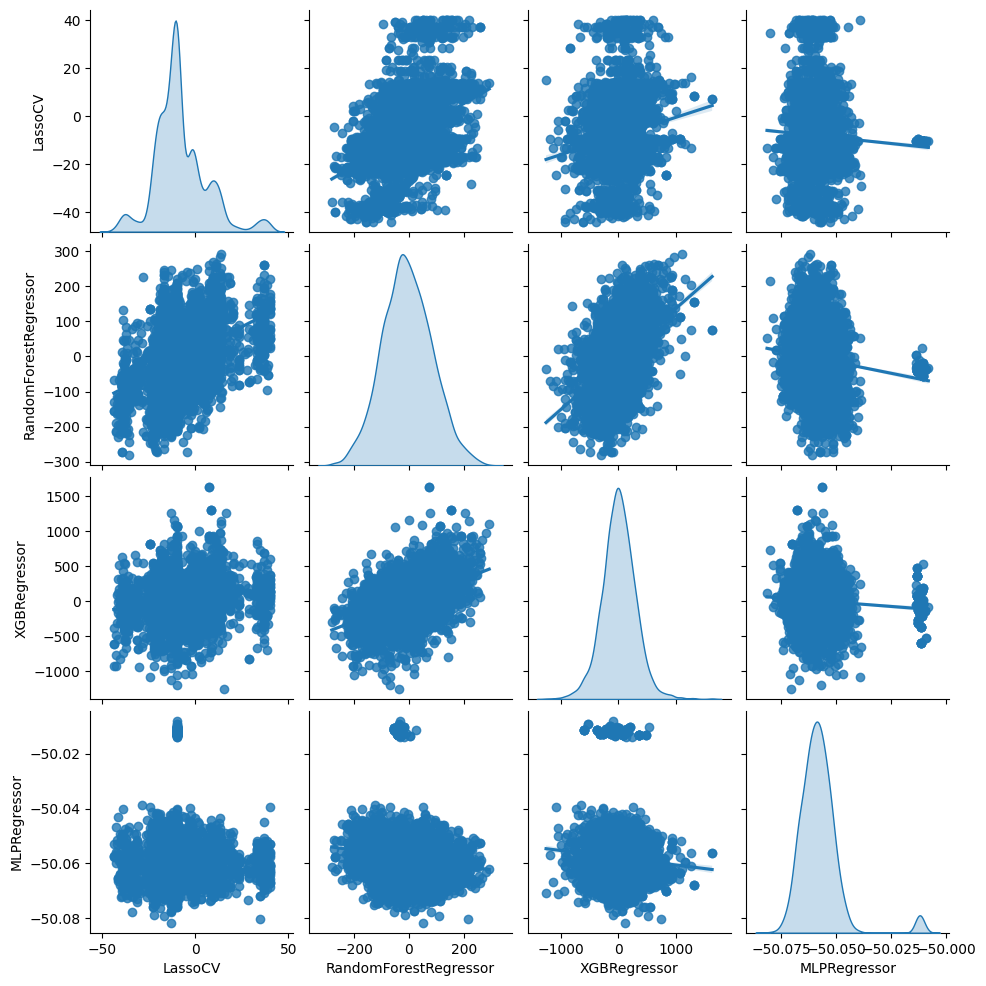

In [12]:
generate_report(results)

From the second table above, we see that regardless of the machine
learning method, the estimated intercept (the first row of the table)
is near 0 and statistically insignificant. Given our results for the unconditional
ATE above, we should expect this. The estimate of the
slopes are also either near 0, very imprecise, or both. This means
that either the conditional average treatment effect is near 0 or that all
four machine learning methods are very poor proxies for the true
conditional average treatment effect.

### Assisted Delivery

Let's see what we get when we look at assisted delivery.

In [13]:
ad = df.loc[X.index, "good_assisted_delivery"]#"midwife_birth"]
results_ad = evaluate_models(models, y=ad)

Correlation in median CATE:


,LassoCV,RandomForestRegressor,XGBRegressor,MLPRegressor
LassoCV,1.000000,0.842070,0.478723,0.900621
RandomForestRegressor,0.842070,1.000000,0.554025,0.709222
XGBRegressor,0.478723,0.554025,1.000000,0.425996
MLPRegressor,0.900621,0.709222,0.425996,1.000000




Best linear projection of CATE


LassoCV  RandomForestRegressor  XGBRegressor  MLPRegressor
blp 0  0.053454               0.045766      0.052432      0.033968
    1  0.453050               0.537908      0.103451      0.347344
se  0  0.020476               0.021299      0.021787      0.022382
    1  0.128880               0.157222      0.077763      0.137142



Group average treatment effects:


LassoCV  RandomForestRegressor  XGBRegressor  MLPRegressor
gate 0 -0.037377              -0.057161     -0.007421      0.004393
     1 -0.027430               0.017016      0.075066     -0.013458
     2  0.002749               0.029643      0.024029     -0.026014
     3  0.096307               0.053311      0.073192      0.050788
     4  0.182684               0.191051      0.090626      0.172496
se   0  0.039096               0.054401      0.052440      0.032378
     1  0.043084               0.043325      0.041245      0.046482
     2  0.043044               0.042134      0.041278      0.051450
     3  0.045872               0.042669      0.042775      0.050129
     4  0.047697               0.050273      0.054001      0.055223

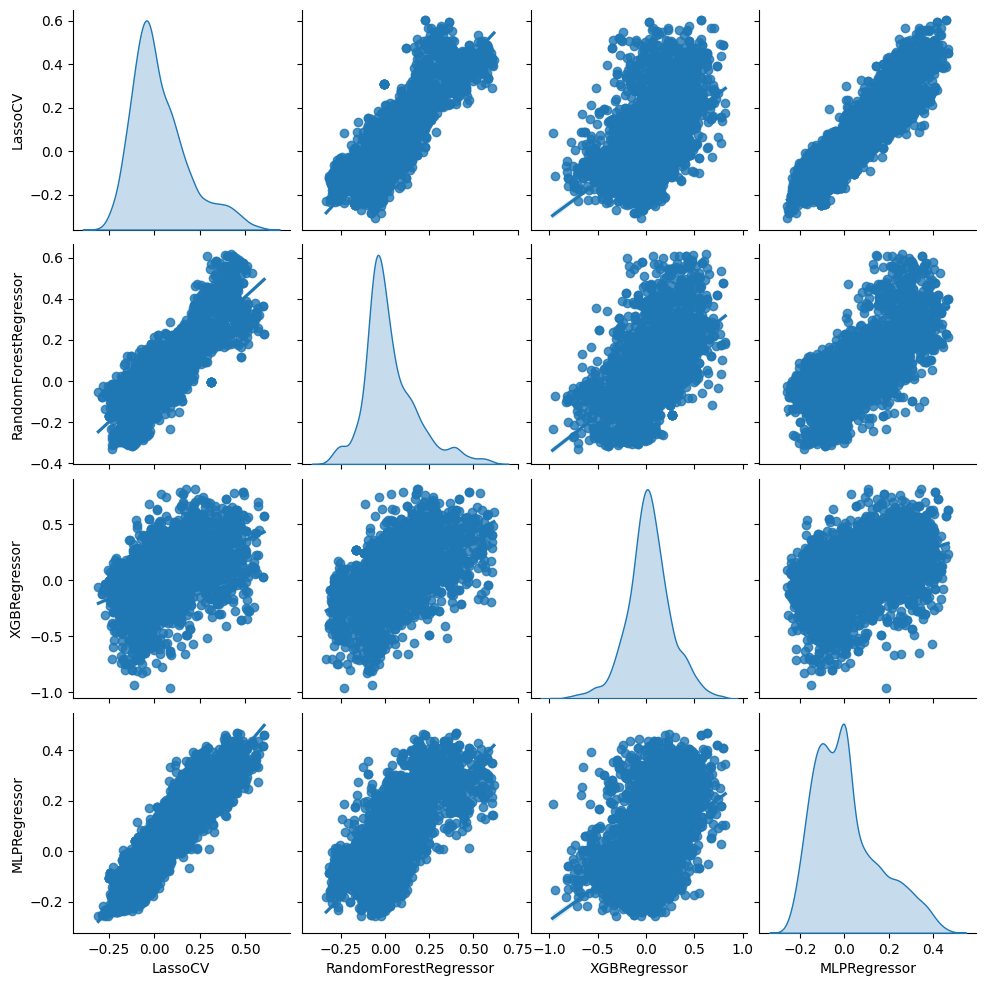

In [14]:
generate_report(results_ad)

Now, the results are more encouraging. For all four machine learning
methods, the slope estimate is positive and statistically
significant. From this, we can conclude that the true conditional
average treatment effect must vary with at least some covariates, and
the machine learning proxies are at least somewhat correlated with the
true conditional average treatment effect.

### Covariate Means by Group

Once we've detected heterogeneity in the grouped average treatment effects
of using medical professionals for assisted delivery, it's interesting to see
how effects vary across groups. This could help
us understand why the treatment effect varies or how to
develop simple rules for targeting future treatments.

In [15]:
df2 = df.loc[X.index, :]
df2["edu99"] = df2.edu == 99
df2["educ"] = df2["edu"]
df2.loc[df2["edu99"], "educ"] = np.nan

variables = [
    "log_xp_percap","agecat","educ","tv","goat",
    "cow","motorbike","hh_cook_wood","pkh_ever"
]

In [16]:
def cov_mean_by_group(y, res, cluster_id):
    n_group = res["gate"].shape[1]
    gate = res["gate"].copy()
    gate_se = gate.copy()
    dat = y.to_frame()

    for i in range(res["cate"].shape[1]):
        S = res["cate"][:, i]
        cutoffs = np.quantile(S, np.linspace(0, 1, n_group+1))
        cutoffs[-1] += 1
        for k in range(n_group):
            dat[f"G{k}"] = ((cutoffs[k] <= S) & (S < cutoffs[k+1])) * 1.0

        g_form = "y ~ -1 + " + " + ".join([f"G{k}" for k in range(n_group)])
        g_reg = smf.ols(g_form, data=dat.astype(float))
        g_fit = g_reg.fit()
        gate[i, :] = g_fit.params.filter(regex="G").values
        rows = ~y.isna()
        gate_se[i, :] = get_treatment_se(g_fit, cluster_id, rows)

    out = pd.DataFrame(dict(
        mean=np.nanmedian(gate, axis=0),
        se=np.nanmedian(gate_se, axis=0),
        group=list(range(n_group))
    ))

    return out

In [17]:
def compute_group_means_for_results(results):
    to_cat = []
    for res in results:
        for v in variables:
            to_cat.append(
                cov_mean_by_group(df2[v], res, loc_id)
                .assign(method=res["name"], variable=v)
            )

    group_means = pd.concat(to_cat, ignore_index=True)
    group_means["plus2sd"] = group_means.eval("mean + 1.96*se")
    group_means["minus2sd"] = group_means.eval("mean - 1.96*se")
    return group_means

In [18]:
group_means_ad = compute_group_means_for_results(results_ad)

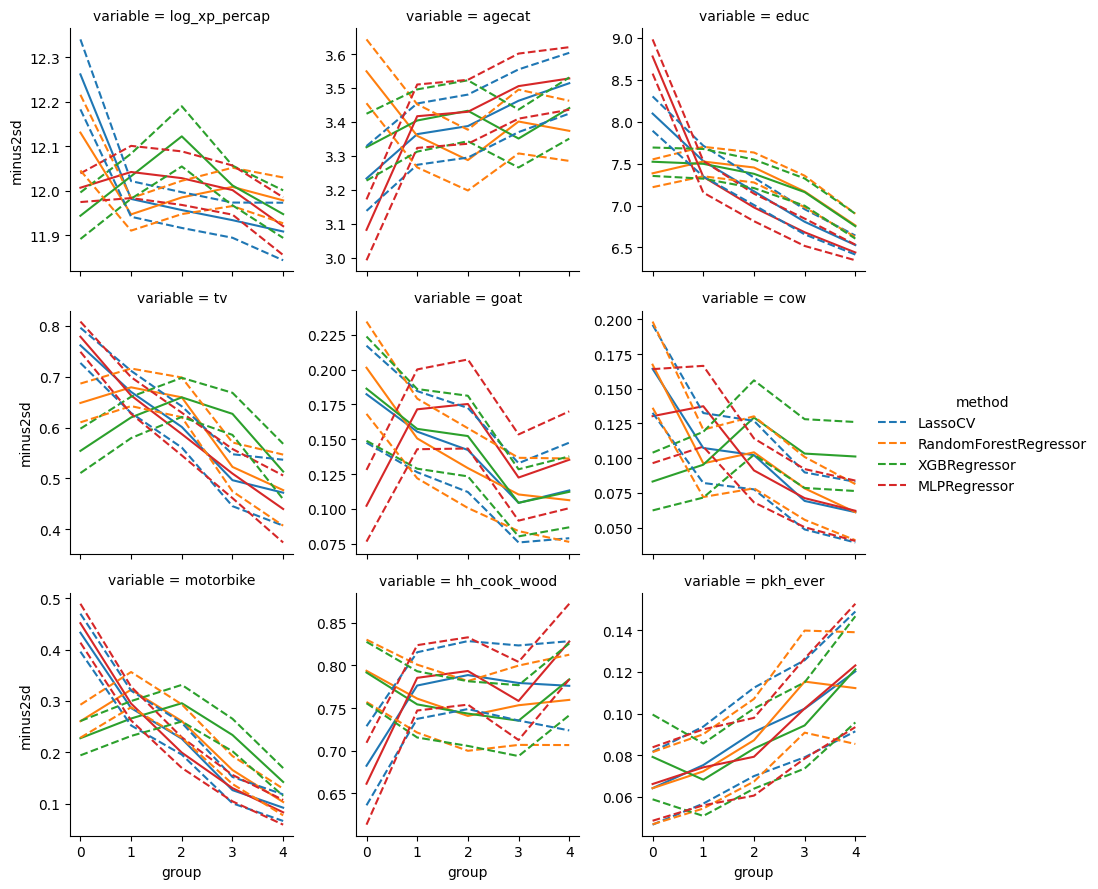

In [19]:
g = sns.FacetGrid(group_means_ad, col="variable", col_wrap=3, hue="method", sharey=False)
g.map(plt.plot, "group", "mean")
g.map(plt.plot, "group", "plus2sd", ls="--")
g.map(plt.plot, "group", "minus2sd", ls="--")
g.add_legend();

From this, we see that the group predicted to be most affected by treatment
are less educated, less likely to own a TV or
motorbike, and more likely to participate in the program.

If we wanted to maximize the program impact with a limited budget, targeting the program towards
less educated and less wealthy mothers could be a good idea. The existing financial incentive
already does this to some extent. As one might expect, a fixed-size
cash incentive has a bigger behavioral impact on less wealthy
individuals. If we want to further target these individuals, we
could alter eligibility rules and/or increase the cash transfer
for those with lower wealth.

### Caution

When exploring treatment heterogeneity like above, we need to
interpret our results carefully. In particular, looking at grouped
treatment effects and covariate means conditional on group leads to
many hypothesis tests (although we never stated null hypotheses or
reported p-values, the inevitable eye-balling of differences in the
above graphs compared to their confidence intervals has the same
issues as formal hypothesis tests).  When we perform many hypothesis
tests, we will likely stumble upon some statistically
significant differences by chance. Therefore, writing about a single large difference found in the
above analysis as though it is our main
finding would be misleading (and perhaps unethical). The correct thing to do is to present all
results that we have looked at.  See [this excellent news article](https://slate.com/technology/2013/07/statistics-and-psychology-multiple-comparisons-give-spurious-results.html)
by statistician Andrew Gelman for more information.

## Causal Trees and Forests

{cite}`het-athey2016b` develop the idea of "causal trees." The purpose and
method are qualitatively similar to the grouped average treatment
effects. The main difference is that the groups in {cite}`het-athey2016b`
are determined by a low-depth regression tree instead of by quantiles
of a noisy estimate of the conditional average treatment effect. As
above, sample-splitting is used to facilitate inference.

Causal trees share many downsides of regression trees. In
particular, the branches of the tree and subsequent results can be
sensitive to small changes in the data.  {cite}`het-wager2018` develop a
causal forest estimator to address this concern. This causal forest
estimates $E[y_i(1) - y_i(0) |X_i=x]$ directly. Unlike most
machine learning estimators, {cite}`het-wager2018` prove that causal
forests are consistent and pointwise asymptotically normal, albeit
with a slower than $\sqrt{n}$ rate of convergence. In practice,
this means that either the sample size must be very large (and/or $x$
relatively low dimension) to get precise estimates.

## References

```{bibliography} applications.bib
:keyprefix: het-
:labelprefix: het
:cited:
```